In [1]:
from __future__ import print_function, division
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sklearn
import seaborn as sns
import json
from pandas.io.json import json_normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline

## Read in preprocessed data

In [2]:
X_train = pd.read_csv('train_dataset.csv', sep = '\t', index_col = 0).drop('cuisine', axis = 1)
cuisines = pd.read_csv('train_dataset.csv', sep = '\t', usecols = ['cuisine'])
cuisines.set_index(X_train.index, inplace = True)

## PCA

In [5]:
np.unique(cuisines)

array(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino',
       'french', 'greek', 'indian', 'irish', 'italian', 'jamaican',
       'japanese', 'korean', 'mexican', 'moroccan', 'russian',
       'southern_us', 'spanish', 'thai', 'vietnamese'], dtype=object)

In [3]:
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'navy', 'turquoise', 'darkorange', 'black', 'coral', 'fuchsia', 'lightblue', 'grey', 'lavender', 'plum', 'tan', 'teal', 'violet', 'salmon', 'darkgreen']

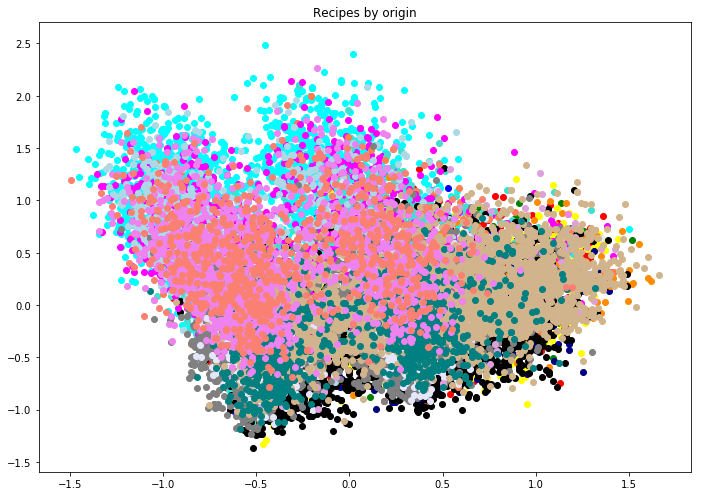

In [7]:
pca = PCA(n_components = 5)
X_pca = pca.fit_transform(X_train)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.title("Recipes by origin")
for i, cur_origin in enumerate(np.unique(cuisines)):
    plt.scatter(X_pca[(cuisines == cur_origin)['cuisine'], 1], X_pca[(cuisines == cur_origin)['cuisine'], 2], c = colors[i])
    
plt.show()

## t-SNE

In [8]:
tsne = TSNE(n_components = 2)
X_tsne = tsne.fit_transform(X_train)

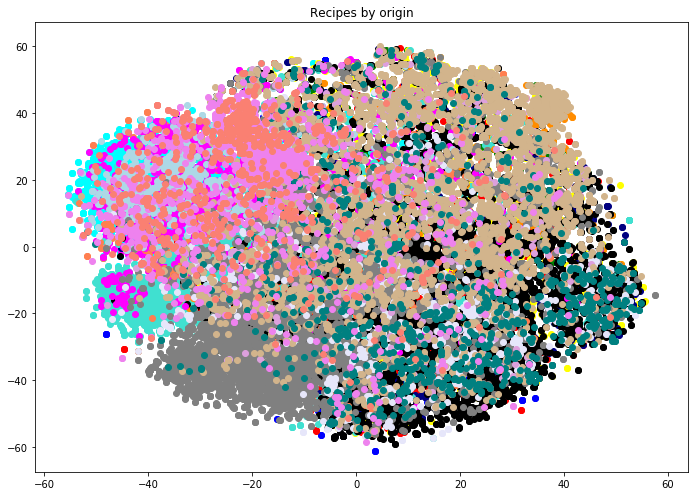

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.title("Recipes by origin")
for i, cur_origin in enumerate(np.unique(cuisines)):
    plt.scatter(X_tsne[(cuisines == cur_origin)['cuisine'], 0], X_tsne[(cuisines == cur_origin)['cuisine'], 1], c = colors[i])
    
plt.show()

In [10]:
tsne2 = TSNE(n_components = 2, early_exaggeration = 30)
X_tsne2 = tsne.fit_transform(X_train)

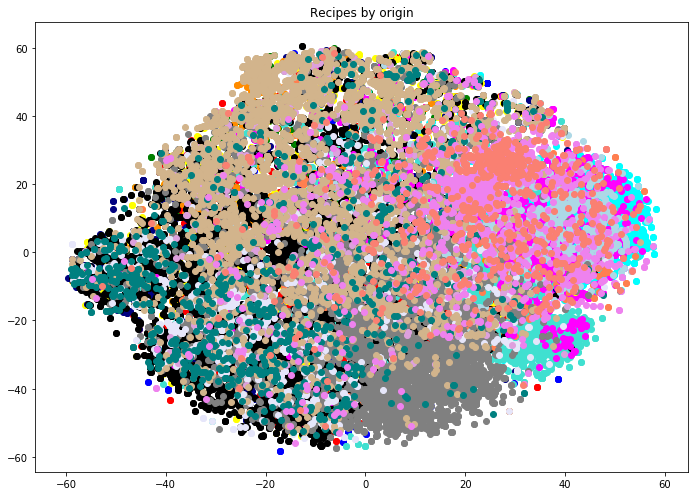

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.title("Recipes by origin")
for i, cur_origin in enumerate(np.unique(cuisines)):
    plt.scatter(X_tsne2[(cuisines == cur_origin)['cuisine'], 0], X_tsne2[(cuisines == cur_origin)['cuisine'], 1], c = colors[i])
    
plt.show()

In [12]:
tsne3 = TSNE(n_components = 2, early_exaggeration = 30, perplexity = 50)
X_tsne3 = tsne.fit_transform(X_train)

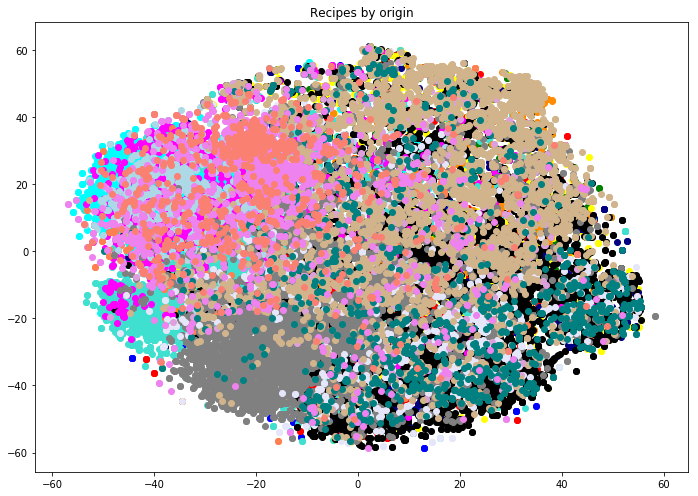

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.title("Recipes by origin")
for i, cur_origin in enumerate(np.unique(cuisines)):
    plt.scatter(X_tsne3[(cuisines == cur_origin)['cuisine'], 0], X_tsne3[(cuisines == cur_origin)['cuisine'], 1], c = colors[i])
    
plt.show()

In [14]:
tsne4 = TSNE(n_components = 2, perplexity = 50)
X_tsne4 = tsne.fit_transform(X_train)

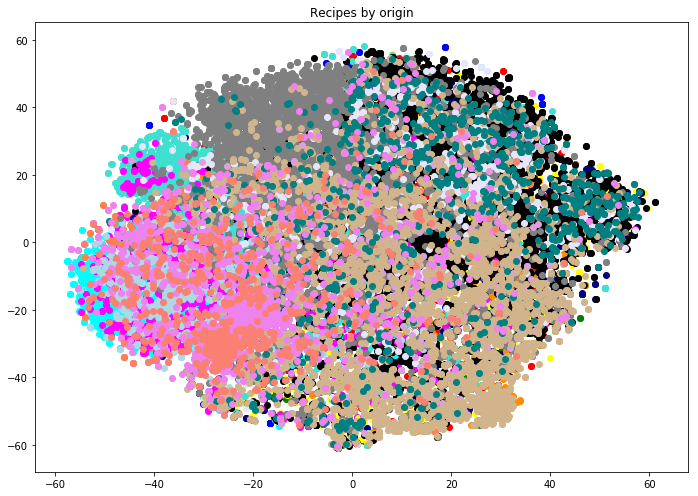

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.title("Recipes by origin")
for i, cur_origin in enumerate(np.unique(cuisines)):
    plt.scatter(X_tsne4[(cuisines == cur_origin)['cuisine'], 0], X_tsne4[(cuisines == cur_origin)['cuisine'], 1], c = colors[i])
    
plt.show()

In [16]:
tsne5 = TSNE(n_components = 2, perplexity = 15, early_exaggeration=ly_exaggeration = 30)
X_tsne5 = tsne.fit_transform(X_train)

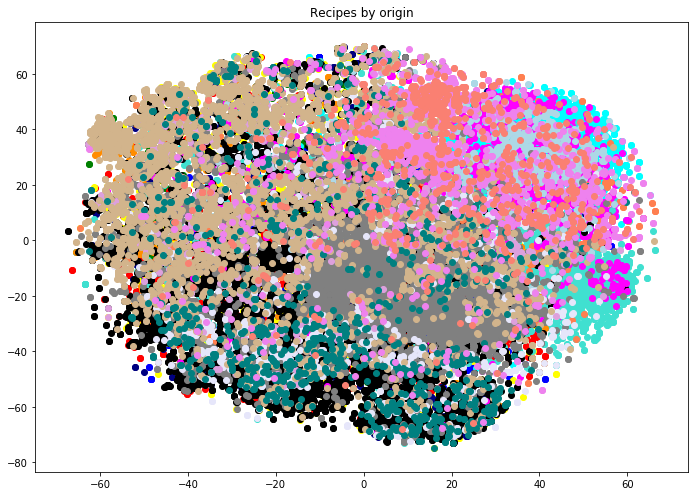

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.title("Recipes by origin")
for i, cur_origin in enumerate(np.unique(cuisines)):
    plt.scatter(X_tsne5[(cuisines == cur_origin)['cuisine'], 0], X_tsne5[(cuisines == cur_origin)['cuisine'], 1], c = colors[i])
    
plt.show()

## Original code

In [ ]:
# dataexploration.ipynb

train_ingr = []
train_id = []
train_cuisine = []

test_ingr = []
test_id = []

with open('data/train.json') as json_file:  
    dict_train = json.load(json_file)
    
with open('data/test.json') as json_file:  
    dict_test = json.load(json_file)

for train_recipe in dict_train:
    concat_ingr_tr = ' '.join([word.replace(" ", "_") for word in train_recipe['ingredients']])
    train_ingr.append(concat_ingr_tr)
    train_id.append(train_recipe['id'])
    train_cuisine.append(train_recipe['cuisine']) # all vocab
        
for test_recipe in dict_test:
    concat_ingr_ts = ' '.join([word.replace(" ", "_") for word in test_recipe['ingredients']])
    test_ingr.append(concat_ingr_ts)  
    test_id.append(test_recipe['id'])

vectorizer = CountVectorizer()

X_train = pd.DataFrame(vectorizer.fit_transform(train_ingr).todense())
X_test  = pd.DataFrame(vectorizer.transform(test_ingr).todense())

X_train.columns = vectorizer.vocabulary_.keys()
X_test.columns = vectorizer.vocabulary_.keys()

X_train['id'] = train_id
X_test['id'] = test_id

X_train['cuisine'] = train_cuisine

In [ ]:
X_test['cuisine'] = 'unknown'
data = [X_train, X_test]
full_data = pd.concat(data)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)


cuisine_counts = full_data.groupby('cuisine').cuisine.count()
cuisine_counts = pd.DataFrame({'cuisine': cuisine_counts.index, 'count': cuisine_counts.values})
cuisine_counts = cuisine_counts.sort_values(['count'], ascending=False)
sns.set(font_scale=2)
sns.set_style("whitegrid")

plt.title("Cuisine popularity distribution")

_ = sns.barplot(ax=ax, x='count', y='cuisine', data=cuisine_counts, orient='h', label='big', color='lightseagreen')
plt.tight_layout()
fig.savefig('cuisine_popularity.pdf')

In [ ]:
#6867 ingredients in total
full_data["number_of_ingredients"] = full_data.iloc[:, :-2].sum(axis=1)

In [ ]:
full_data.shape #49718 total examples (including unknown)

In [ ]:
# number of ingredients per recipe

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.title("Recipe length distribution")
_ = sns.distplot(full_data['number_of_ingredients'], kde=True, label="big")
fig.savefig('recipes_length.pdf')

In [ ]:
# skewed distribution, outliers: very long and very short recipes

In [ ]:
no_outliers = full_data.loc[full_data['number_of_ingredients'].isin(range(4, 30))]

In [ ]:
no_outliers.shape

In [ ]:
# Recipe length distribution after removing outliers

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.title("Recipe length distribution after outliers removal")
_ = sns.distplot(no_outliers['number_of_ingredients'])
fig.savefig('recipes_length_no_outliers.pdf')

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(no_outliers.iloc[:, :-3])

In [ ]:
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

In [ ]:
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'navy', 'turquoise', 'darkorange', 'black', 'coral', 'fuchsia', 'lightblue', 'grey', 'lavender', 'plum', 'tan', 'teal', 'violet', 'salmon', 'darkgreen']

In [ ]:
cuisines = no_outliers['cuisine'].values
print(len(set(cuisines)))
print(len(colors))

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.title("First 2 PCA components")
for i, cur_cuisine in enumerate(set(cuisines)):
    plt.scatter(X_pca[cuisines == cur_cuisine, 0], X_pca[cuisines == cur_cuisine, 1], c=colors[i])

fig.savefig('pca.pdf')

In [ ]:
# group by location
print(set(cuisines))

In [ ]:
west = ['french', 'irish', 'british', 'russian', 'cajun_creole'] # Europe and US
east = ['chinese', 'vietnamese', 'japanese', 'filipino', 'korean', 'thai']
south = ['southern_us', 'jamaican', 'mexican', 'brazilian']
mediterranean = ['greek', 'spanish', 'italian', 'moroccan']
indian = ['indian']

def label_origin(row):
    if row['cuisine'] in west:
        return 'west'
    if row['cuisine'] in east:
        return 'east'
    if row['cuisine'] in mediterranean:
        return 'mediterranean'
    if row['cuisine'] in indian:
        return 'indian'
    if row['cuisine'] in south:
        return 'south'

X_train['origin'] = X_train.apply (lambda row: label_origin(row),axis=1)

    
colors = ['blue', 'green', 'red', 'yellow', 'pink']
origins = X_train['origin'].values

# smarter method...

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train.iloc[:, :-3])

In [ ]:
print(set(origins))

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.title("Recipes by origin")
for i, cur_origin in enumerate(set(origins)):
    plt.scatter(X_pca[origins == cur_origin, 0], X_pca[origins == cur_origin, 1], c=colors[i])

fig.savefig('pca_origins.pdf')

interpretation: 2 first PCA components aren't enough to represent the data (explained variance ratio (first two components): [0.0298653  0.02821523])

# PCA on the transposed matrix, labels instead of dots (sort the ingredients, take the most common ones)
# tSNE
# tf-idf

In [ ]:
transposed = no_outliers.transpose().iloc[:-3, :]

In [ ]:
transposed['count'] = transposed.sum(axis=1) # number of ingredients

In [ ]:
transposed['name'] = transposed.index.values

In [ ]:
transposed

In [ ]:
transposed = transposed.sort_values(['count'], ascending=False).iloc[:100]
transposed

In [ ]:
ingr_count = no_outliers.sum(axis=0)

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)


transposed = transposed.sort_values(['count'], ascending=False).iloc[:100]
sns.set(font_scale=2)
sns.set_style("whitegrid")

plt.title("Ingredients popularity distribution")

_ = sns.barplot(ax=ax, x='count', y='name', data=transposed, orient='h', label='big', color='lightseagreen')
plt.tight_layout()
fig.savefig('ingredient_popularity.pdf')

In [ ]:
ingredients = transposed.index.values
ingredients

In [ ]:
top_ingredients = 

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(transposed[:100])

In [ ]:
df = pd.DataFrame(X_pca, index=ingredients[:100], columns=['x', 'y'])

In [ ]:
df

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos)
    
fig.savefig("PCA.pdf")   

In [ ]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(transposed)

In [ ]:
X_tsne

In [ ]:
X_pca

In [ ]:
X_train = pd.read_csv('train_dataset.csv', sep='\t')
X_train = X_train.drop('Unnamed: 0', axis=1)
ingr_count = X_train.sum(axis=0)

In [ ]:
X_train = X_train.transpose()

In [ ]:
X_train

In [ ]:
X_train['count'] = ingr_count.values

In [ ]:
X_train = X_train.sort_values(by='count', ascending=False)

In [ ]:
X_train

In [ ]:
X_train.iloc[:, :-1]

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train.iloc[:, :-1])

In [ ]:
names = X_train.index.values

In [ ]:
df = pd.DataFrame(X_pca, index=names, columns=['x', 'y'])

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(31.7, 28.27)
sns.set(font_scale=2)
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos)
    
plt.title("Dimensionality reduction of recipe ocurrences per ingredient using PCA") 
plt.tight_layout()
fig.savefig("PCA.pdf")   

"|  It is highly recommended to use another dimensionality reduction
 |  method (e.g. PCA for dense data or TruncatedSVD for sparse data)
 |  to reduce the number of dimensions to a reasonable amount (e.g. 50)
 |  if the number of features is very high.""

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
X = svd.fit_transform(X_train.iloc[:, :-1])  

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [ ]:
X_tsne

In [ ]:
df_tsne = pd.DataFrame(X_pca, index=names, columns=['x', 'y'])

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(31.7, 28.27)
sns.set(font_scale=2)
ax.scatter(df_tsne['x'], df_tsne['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos)
    
plt.title("Dimensionality reduction of recipe ocurrences per ingredient using Truncated SVD and tSNE")   
plt.tight_layout()
fig.savefig("tSNE.pdf")   

In [ ]:
X_train['name'] = X_train.index.values

In [ ]:
X_train

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)


sns.set_style("whitegrid")

plt.title("The most popular ingredients")

_ = sns.barplot(ax=ax, x='count', y='name', data=X_train, orient='h', label='big', color='lightseagreen')
plt.tight_layout()
fig.savefig('ingredients_popularity.pdf')